## **MoroccoAI Data Challenge (Edition 001)**

This notebook walks through The prcoccess of Loading , Preparing and Training the first model of object Object Detection that detect Licence Plates in Images.

<br>

### **Overview**

In Morocco, the number of registered vehicles doubled between 2000 and 2019. In 2019, a few months before lockdowns due to the Coronavirus Pandemic, 8 road fatalities were recorded per 10 000 registered vehicles. This rate is extremely high when compared with other IRTAD countries. The National Road Safety Agency (NARSA) established the road safety strategy 2017-26 with the main target to reduce the number of road deaths by 50% between 2015 and 2026 [1].Is crucial for law enforcement and authorities in order to assure the safety of the roads and to check the registration and the licence of the vehicles.
Therefore the aim to automate this task is very beneficial.

**This Jupyter Notebook only loads the trained Checkpoints, You can find Training Notebook in the next link.**

💡 Recommendation: [The Jupyter Notebook were we you can use both model to extract a csv that contain images ID, and detected Characters ](https://colab.research.google.com/drive/1ivUs4cWB9aR77MqV3uK1XR9_TPET0aCs?usp=sharing).


<br>

### **Dataset**

The dataset is 654 jpg pictures of the front or back of vehicles showing the license plate. They are of different sizes and are mostly cars. The plate license follows Moroccan standard.

For each plate corresponds a string (series of numbers and latin characters) labeled manually. The plate strings could contain a series of numbers and latin letters of different length. Because letters in Morocco license plate standard are Arabic letters, we will consider the following transliteration: a <=> أ, b <=> ب, j <=> ج (jamaa), d <=> د , h <=> ه , waw <=> و, w <=> w (newly licensed cars), p <=> ش (police), fx <=> ق س (auxiliary forces), far <=> ق م م (royal army forces), m <=>المغرب, m <=>M. For example:

the string “123ب45” have to be converted to “12345b”,<br>
the string “123و4567” to “1234567waw”,<br>
the string “12و4567” to “1234567waw”,<br>
the string “1234567ww” to “1234567ww”, (remain the same)<br>
the string “1234567far” to “1234567ق م م”,<br>
the string “1234567m” to “1234567المغرب", etc.
<br>

We offer the plate strings of 450 images (training set). The remaining 204 unlabeled images will be the test set. The participants are asked to provide the plate strings in the test set.

<br>

### **Our Approach & Models**

Our approach was to use Object Detection to detect plate characters from images. We have chosen to build two models separately instead of using libraries directly like easyOCR or Tesseract due to its weaknesses in handling the variance in the shapes of Moroccan License plates.
The first model was trained to detect the licence plate to be then cropped from the original image, which will be then passed into the second model that was trained to detect the characters. 

This notebook will be showing a code example on pretrained faster-rcnn model for both Object detection tasks,  using library called detectron2 developed by FaceBook AI Research Laboratory (FAIR) based on Pytorch.

<br>

### **Detectron2**

#### ![Detectron2 Logo](https://raw.githubusercontent.com/facebookresearch/detectron2/085fda47bc49f2cdd9c05a895580b2b31fcdb6c3/.github/Detectron2-Logo-Horz.svg)

Detectron2 is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. It is the successor of Detectron and maskrcnn-benchmark. It supports a number of computer vision research projects and production applications in Facebook.


### **Fast-RCNN**

#### ![Fast-RCNN Architecture ](https://www.researchgate.net/profile/Akif-Durdu/publication/334987612/figure/fig3/AS:788766109224961@1565067903984/High-level-diagram-of-Faster-R-CNN-16-for-generic-object-detection-2-Inception-v2-The.ppm)

This version of the notebook doesn't contain the inference part since it's still on development. Once the inference and deployment part is done this will noteboook will be update.

### **About**

[MoroccoAI](https://morocco.ai/) MoroccoAI is an initiative led by AI experts in Morocco and abroad to promote AI growth in Morocco across the spectrum.


#### ![MoroccoAI Logo](https://morocco.ai/wp-content/uploads/2020/03/MoroccoAI_Logo.png)







<h1>Training Faster-RCNN for Licence Plates Detection</h1>

<h3>installing detectron2</h3>
<p> First thing to do is try to Install detectron2 and Restart the runtime so all installed libraires get loaded</p>

In [ ]:
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

Downloading UM6P dataset

In [ ]:

!wget https://msda.um6p.ma/api/upload/files/DATA.rar --no-check-certificate

--2021-12-14 20:31:25--  https://msda.um6p.ma/api/upload/files/DATA.rar
Resolving msda.um6p.ma (msda.um6p.ma)... 196.200.180.55
Connecting to msda.um6p.ma (msda.um6p.ma)|196.200.180.55|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2653518819 (2.5G) [application/x-rar-compressed]
Saving to: ‘DATA.rar’

DATA.rar            100%[===================>]   2.47G  1012KB/s    in 43m 32s 

2021-12-14 21:14:58 (992 KB/s) - ‘DATA.rar’ saved [2653518819/2653518819]



extracting rar file

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("DATA.rar", outdir=".")

     |████████████████████████████████| 77 kB 3.2 MB/s 
patool: Extracting /content/drive/MyDrive/DATA.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/DATA.rar
patool:     with cwd='.'
patool: ... /content/drive/MyDrive/DATA.rar extracted to `.'.


'.'

<h3>Importing detecron2 and additional packages</h3>

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

<h3>Data Loading and Prepartion for detectron2</h3>
<p>Here we aimed to create a function that load annotation from csv file and 
make it ready to be consumed by Faster-RCNN model.
</p>

In [ ]:
import pandas as pd

def get_plates_dicts(img_dir):
  df = pd.read_csv("DATA/Segmentation/Images.csv", sep=";")

  dataset_dicts = []
  for i in range(len(df)):

    objs = []
    row = df.iloc[i,:]

    record = {}

    img_name = os.path.join(img_dir, row['Image name'])
    width, height = row['Width'], row['Height']
    record["file_name"] = img_name
    record["image_id"] = i
    record["height"] = height
    record["width"] = width
    

    x_min, y_min = row['x min'], row['y min']
    w = row['x max - x min']
    h = row['y max - ymin']

    
    obj = {
        "bbox": [x_min, y_min, w, h],
        "bbox_mode": BoxMode.XYWH_ABS,

         "category_id": 0,
          }
    
    objs.append(obj)

    record['annotations'] = objs
    
    dataset_dicts.append(record)

  return dataset_dicts    





<h3>DataSet Registration</h3>

In [ ]:
d = 'DATA/Segmentation/Image'
DatasetCatalog.register("licences", lambda d = d: get_plates_dicts(d))
MetadataCatalog.get("licences").set(thing_classes=["licence"])

licences_metadata = MetadataCatalog.get("licences")

<h2>Plotting examples from Training Set</h2>

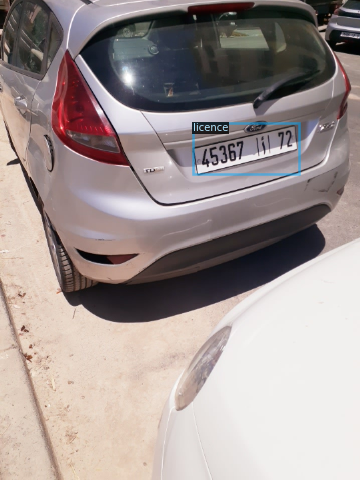

In [ ]:
import matplotlib.pyplot as plt
dataset_dicts = get_plates_dicts('DATA/Segmentation/Image')

for dd in random.sample(dataset_dicts, 1):
    img = cv2.imread(dd["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=licences_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(dd)
    cv2_imshow(out.get_image()[:, :, ::-1])

<h1>Trainig a Faster-RCNN Model for Licence Plates Detection</h1>

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("licences",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # Learning Rate
cfg.SOLVER.MAX_ITER = 3000    
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (licence). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


cfg.OUTPUT_DIR = 'Plate_Detection_Model'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/16 10:16:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:05, 30.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

[12/16 10:16:37 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/16 10:17:05 d2.utils.events]:  eta: 1:06:32  iter: 19  total_loss: 0.9479  loss_cls: 0.6843  loss_box_reg: 0.07501  loss_rpn_cls: 0.1163  loss_rpn_loc: 0.01002  time: 1.3128  data_time: 0.1725  lr: 4.9953e-06  max_mem: 2303M
[12/16 10:17:32 d2.utils.events]:  eta: 1:04:36  iter: 39  total_loss: 0.7913  loss_cls: 0.6048  loss_box_reg: 0.02732  loss_rpn_cls: 0.1029  loss_rpn_loc: 0.01002  time: 1.3425  data_time: 0.1772  lr: 9.9902e-06  max_mem: 2303M
[12/16 10:17:58 d2.utils.events]:  eta: 1:04:10  iter: 59  total_loss: 0.6536  loss_cls: 0.4663  loss_box_reg: 0.06756  loss_rpn_cls: 0.07672  loss_rpn_loc: 0.006726  time: 1.3250  data_time: 0.0883  lr: 1.4985e-05  max_mem: 2303M
[12/16 10:18:25 d2.utils.events]:  eta: 1:03:55  iter: 79  total_loss: 0.5912  loss_cls: 0.3451  loss_box_reg: 0.09146  loss_rpn_cls: 0.1091  loss_rpn_loc: 0.01037  time: 1.3225  data_time: 0.0977  lr: 1.998e-05  max_mem: 2303M
[12/16 10:18:50 d2.utils.events]:  eta: 1:02:54  iter: 99  total_loss: 0.5107  loss

<h1>Inference</h1>

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


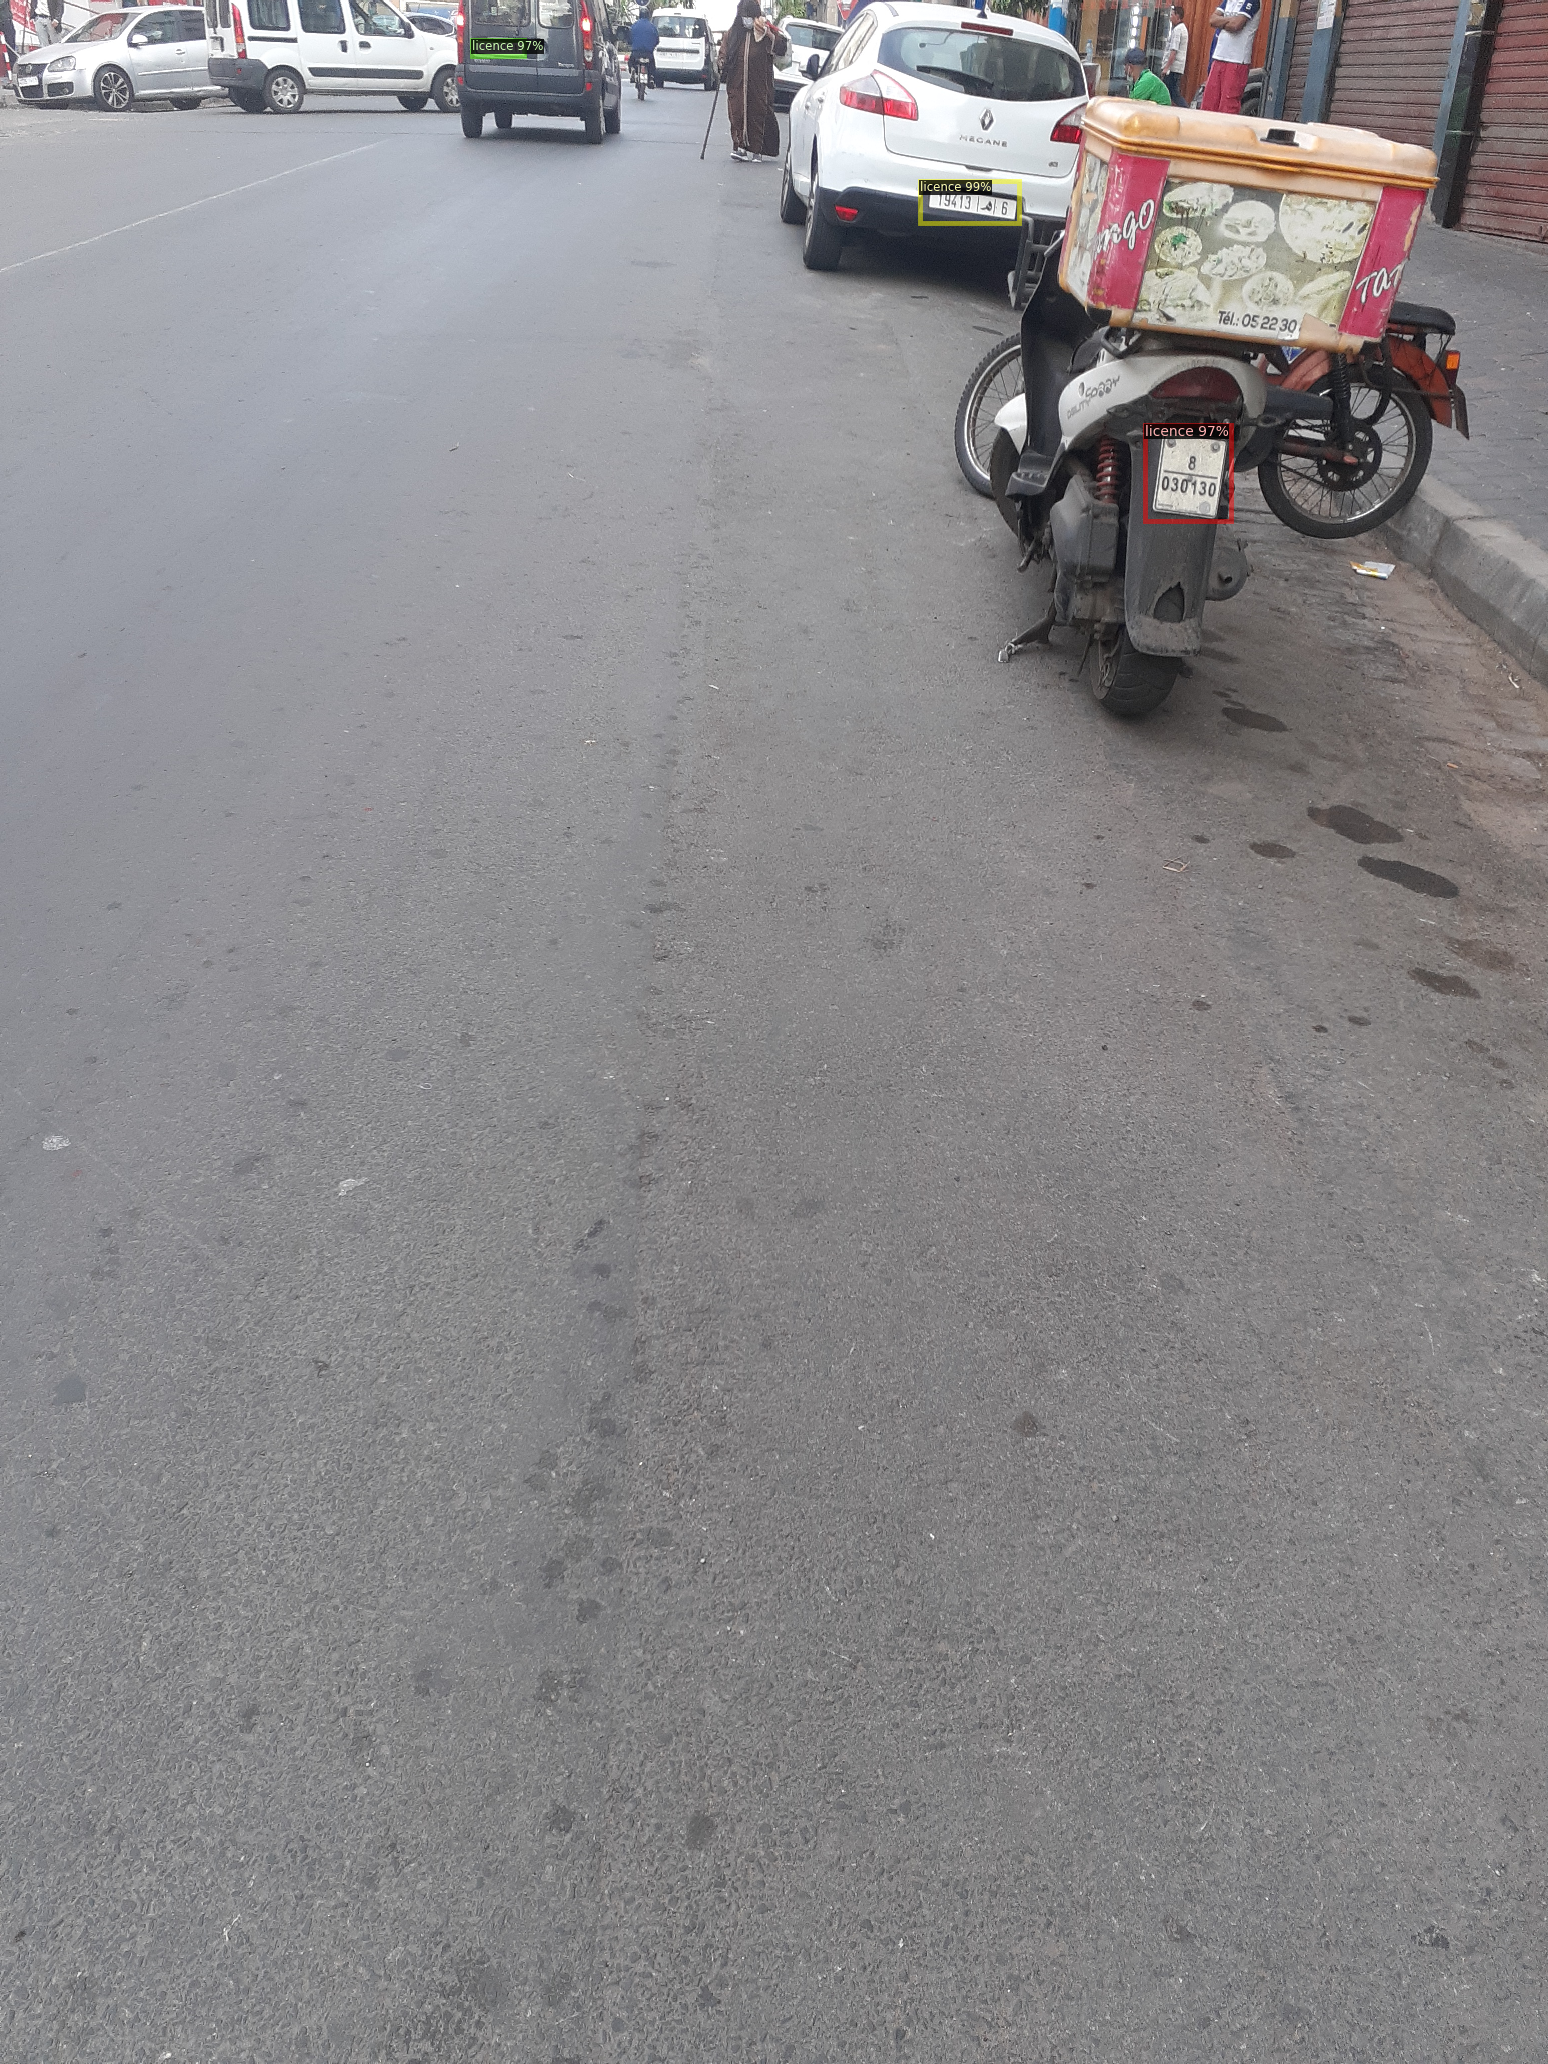

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_plates_dicts('DATA/Segmentation/Image')
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=licences_metadata, 
                   scale=0.5, 
                   
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])